# Optimierung neu

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [3]:
import xgboost
print(xgboost.__version__)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [8]:
# === 1. Daten laden ===
X_train_res = pd.read_csv("Data/preprocessed/X_train_res.csv")
y_train_res = pd.read_csv("Data/preprocessed/y_train_res.csv")['target']  # achte auf die Spaltennamen

X_valid = pd.read_csv("Data/preprocessed/X_valid_enc.csv")
y_valid = pd.read_csv("Data/preprocessed/y_valid.csv")['target']

X_test  = pd.read_csv("Data/preprocessed/X_test_enc.csv")
y_test  = pd.read_csv("Data/preprocessed/y_test.csv")['target']

### Randomized Search ohne early stopping mit 20 wiederholungen

Fitting 10 folds for each of 20 candidates, totalling 200 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:20:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01}
Best CV score: 0.525294514324837

Test Accuracy: 0.5427065026362039

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.39      0.39       658
           1       0.73      0.57      0.64      1558
           2       0.42      0.64      0.51       629

    accuracy                           0.54      2845
   macro avg       0.51      0.53      0.51      2845
weighted avg       0.58      0.54      0.55      2845



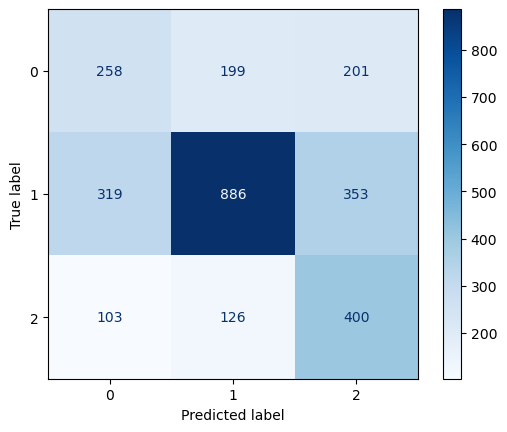

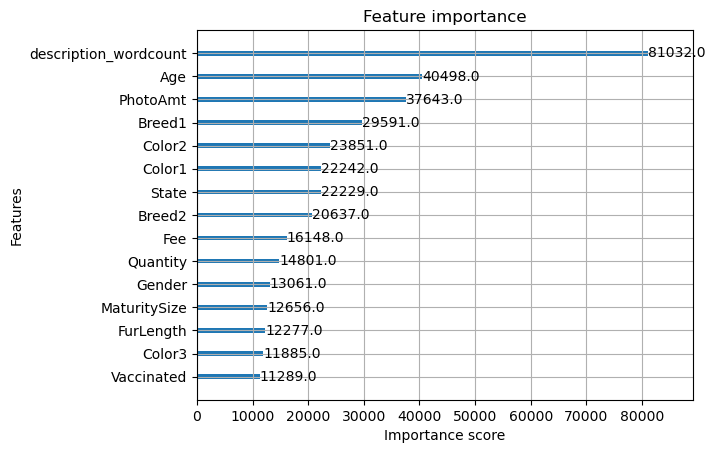

In [9]:
# === 2. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 3. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 4. Randomized Search ===
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 5. Fit Randomized Search ===
random_search.fit(X_train_res, y_train_res)

# === 6. Ergebnisse ===
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 7. Test-Set Evaluation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 8. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 9. Feature Importance ===
plot_importance(best_model, importance_type="weight", max_num_features=15)
plt.show()


### Randomized Search ohne early stopping mit 100 wiederholungen

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\Users\faulh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:33:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.02}
Best CV score: 0.5259755585927144

Test Accuracy: 0.5398945518453427

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.42      0.40       658
           1       0.74      0.56      0.64      1558
           2       0.42      0.61      0.50       629

    accuracy                           0.54      2845
   macro avg       0.51      0.53      0.51      2845
weighted avg       0.58      0.54      0.55      2845



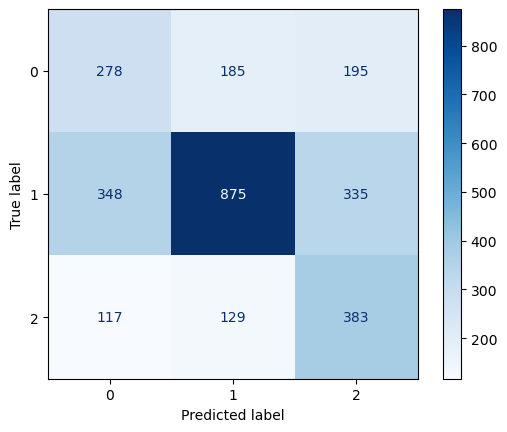

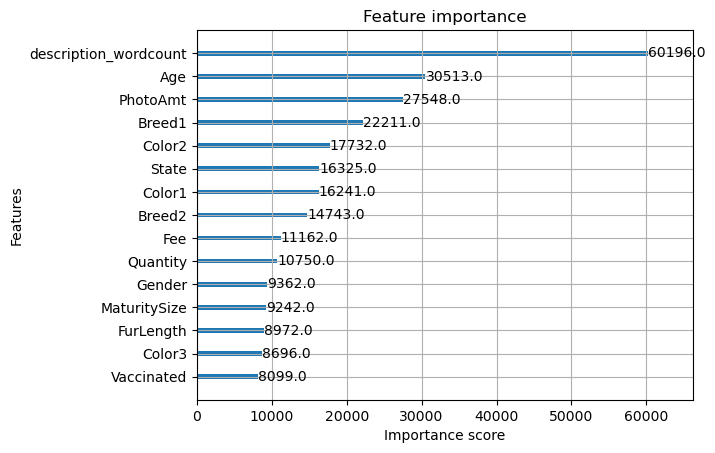

In [10]:
# === 2. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 3. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 4. Randomized Search ===
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring="accuracy",
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 5. Fit Randomized Search ===
random_search.fit(X_train_res, y_train_res)

# === 6. Ergebnisse ===
print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 7. Test-Set Evaluation ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 8. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 9. Feature Importance ===
plot_importance(best_model, importance_type="weight", max_num_features=15)
plt.show()


### Random Search mit early stopping mit 20 Iterationen

In [23]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 2. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 3. Randomized Search (ohne Early Stopping hier) ===
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 4. Fit Randomized Search ===
random_search.fit(X_train_res, y_train_res)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 5. Finale Modell mit Early Stopping ===
best_params = random_search.best_params_

final_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    **best_params
)

# --- Early Stopping mit Validierungsset ---
final_xgb.fit(
    X_train_res, y_train_res,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=10,   # nur eine Zahl, keine Liste
    verbose=True
)

# === 6. Test-Set Evaluation ===
y_pred = final_xgb.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 8. Feature Importance ===
plot_importance(final_xgb, importance_type="weight", max_num_features=15)
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


exception calling callback for <Future at 0x1b8e6ba2bd0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\faulh\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\faulh\anaconda3\Lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\__init__.py", line 82, in <module>
    from .base import clone
  File "c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\base.py", line 17, in <module>
    from .utils import _IS_32BIT
  File "c:\Users\faulh\anaconda3\Lib\site-packages\sklearn\utils\__init__.py", line 19, in <module>
    from .murmurhash import murmurhash3_32
  File "sklearn\

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Random Search mit early stopping mit 100 Iterationen

In [ ]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. Randomized Search Parameter ===
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 1.0]
}

# === 2. XGBoost Modell ===
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# === 3. Randomized Search (ohne Early Stopping hier) ===
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring="accuracy",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 4. Fit Randomized Search ===
random_search.fit(X_train_res, y_train_res)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)

# === 5. Finale Modell mit Early Stopping ===
best_params = random_search.best_params_

final_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    **best_params
)

# --- Early Stopping mit Validierungsset ---
final_xgb.fit(
    X_train_res, y_train_res,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=10,   # nur eine Zahl, keine Liste
    verbose=True
)

# === 6. Test-Set Evaluation ===
y_pred = final_xgb.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
labels_all = [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_all)
disp.plot(cmap="Blues")
plt.show()

# === 8. Feature Importance ===
plot_importance(final_xgb, importance_type="weight", max_num_features=15)
plt.show()
